# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://www.travelinusa.us/wp-content/uploads/sites/3/2017/11/Painted-Ladies-San-Francisco-01.jpg).

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment.

In [ ]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)
DATA_FILE_PATH = '/content/housing.csv'
# Your code goes here for this section.
def get_data():
  return pd.read_csv(DATA_FILE_PATH)

data = get_data()

Data Discovery, Visualization, and Cleaning

In [ ]:
import os

print("Data Overview")
print(data.info())
print()
file_size = os.path.getsize(DATA_FILE_PATH) / (10 ^ 6)
print("File Size is :", file_size, "MB")
print()

data = get_data()
data.shape
print("Entries:", data.shape[0])
print("Features:", data.shape[1])
print()

categorical_data = data.select_dtypes(include=['object'])
print("Categorical Features:", categorical_data.shape[1])
print()

print("Missing values:")
print(data.isnull().sum())
print()

print("Statistical Overview:")
print(data.describe())
print()

print("Categorical Data")
print(data["ocean_proximity"].value_counts())

Data Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None

File Size is : 118627.41666666667 MB

Entries: 20640
Features: 10

Categorical Features: 1

Missing values:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms     

Histograms

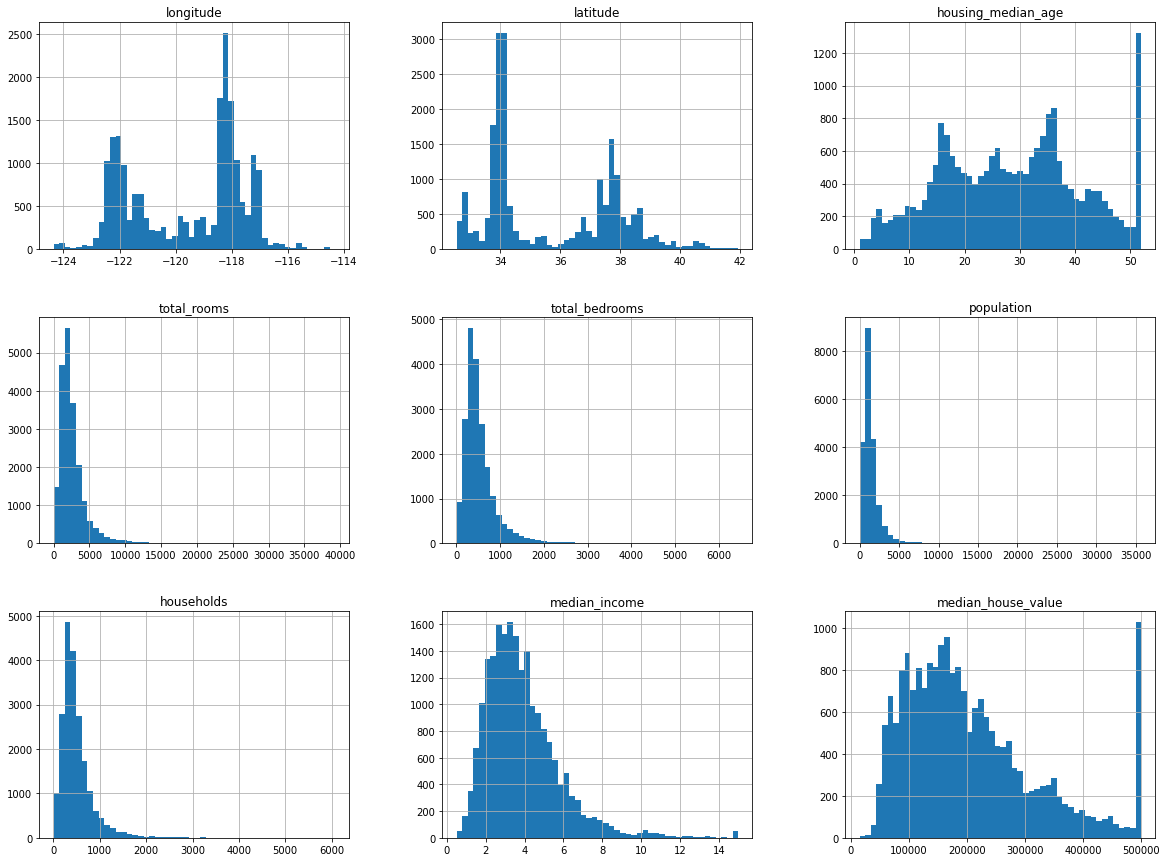

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

Applying Log transformation to "Linearize"

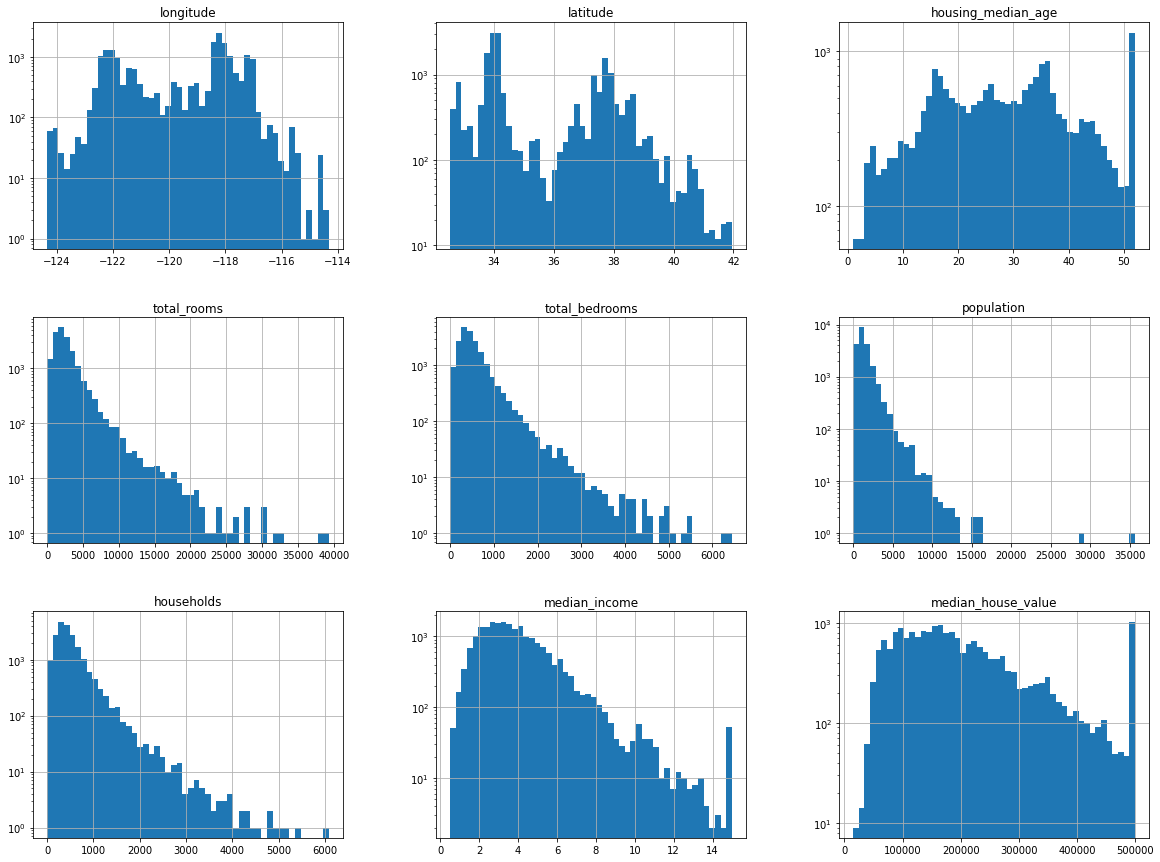

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15), log=True)
plt.show()

Seems to be most useful for:
- total_rooms
- total_bedrooms
- population
- households

Partly useful for all of the data except:
- household_median_age

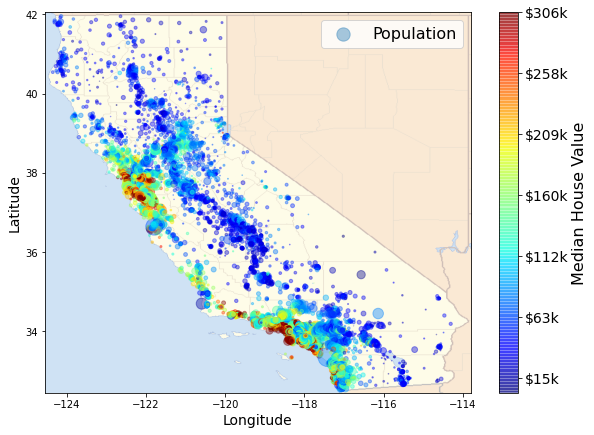

In [ ]:
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.pyplot as plt
# Read the image of California (make sure you have it in the directory)
california_img=mpimg.imread('/content/california.png')
ax = data.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=data['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

Pipeline Stratgies:
- Take log of income


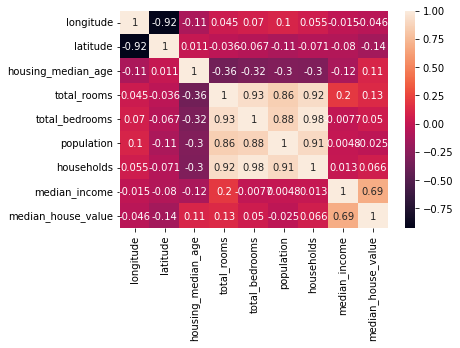

In [ ]:
import seaborn as sn

corr_matrix = data.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

Seeting up the piplines and train, test data:

Numerical:
- Log, std scalar (no log on median_household_age)
- Use the median imputer strategy for total bedrooms

Catergorical:
- One hot encoding on ocean proximity

In [ ]:
housing_nums = data.select_dtypes(exclude=['object'])
housing_cat = data.select_dtypes(include=['object'])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_nums)
print(housing_num_tr.shape)
housing_num_tr[0:5]

(20640, 9)


array([[-1.32783522,  1.05254828,  0.98214266, -0.8048191 , -0.97247648,
        -0.9744286 , -0.97703285,  2.34476576,  2.12963148],
       [-1.32284391,  1.04318455, -0.60701891,  2.0458901 ,  1.35714343,
         0.86143887,  1.66996103,  2.33223796,  1.31415614],
       [-1.33282653,  1.03850269,  1.85618152, -0.53574589, -0.82702426,
        -0.82077735, -0.84363692,  1.7826994 ,  1.25869341],
       [-1.33781784,  1.03850269,  1.85618152, -0.62421459, -0.71972345,
        -0.76602806, -0.73378144,  0.93296751,  1.16510007],
       [-1.33781784,  1.03850269,  1.85618152, -0.46240395, -0.61242263,
        -0.75984669, -0.62915718, -0.012881  ,  1.17289952]])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat', OneHotEncoder(handle_unknown='ignore')),
    ('std_scaler', StandardScaler(with_mean=False)),
])

housing_cat_tr = cat_pipeline.fit_transform(housing_cat)
print(housing_cat_tr.shape)
housing_cat_tr.toarray()

(20640, 5)


array([[0.        , 0.        , 0.        , 3.18400629, 0.        ],
       [0.        , 0.        , 0.        , 3.18400629, 0.        ],
       [0.        , 0.        , 0.        , 3.18400629, 0.        ],
       ...,
       [0.        , 2.14840329, 0.        , 0.        , 0.        ],
       [0.        , 2.14840329, 0.        , 0.        , 0.        ],
       [0.        , 2.14840329, 0.        , 0.        , 0.        ]])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_nums)
# print("Numerical Attributes:", num_attribs)
cat_attribs = list(housing_cat)
# print("Cat Attributes:", cat_attribs)

final_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

housing_prepared = final_pipeline.fit_transform(data)

print("Before")
print(data.shape)
print("After")
print(housing_prepared.shape)
print(housing_prepared)

Before
(20640, 10)
After
(20640, 14)
[[-1.32783522  1.05254828  0.98214266 ...  0.          3.18400629
   0.        ]
 [-1.32284391  1.04318455 -0.60701891 ...  0.          3.18400629
   0.        ]
 [-1.33282653  1.03850269  1.85618152 ...  0.          3.18400629
   0.        ]
 ...
 [-0.8237132   1.77823747 -0.92485123 ...  0.          0.
   0.        ]
 [-0.87362627  1.77823747 -0.84539315 ...  0.          0.
   0.        ]
 [-0.83369581  1.75014627 -1.00430931 ...  0.          0.
   0.        ]]


- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
max_of_features = np.amax(housing_prepared, axis=0)
min_of_features = np.amin(housing_prepared, axis=0)
print(max_of_features)
print(min_of_features)

[ 2.62528006  2.95806762  1.85618152 16.81557992 14.08778897 30.25033022
 14.60152007  5.85828581  2.54041094  2.01329405  2.14840329 64.25729719
  3.18400629  2.98547341]
[-2.38599234 -1.447568   -2.19618048 -1.20728295 -1.27768769 -1.25612255
 -1.30398368 -1.77429947 -1.66264085  0.          0.          0.
  0.          0.        ]


In [ ]:
from scipy.sparse.construct import random
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).

# Default Hyperparemters
num_clusters = 2
p = 2

def random_centroid():
  centriod = np.empty([14,])
  for i in range(14):
    centriod[i] = np.random.uniform(low=min_of_features[i], high=max_of_features[i])
  return centriod

def distence(x, y, power=p):
  abs_diff_to_p = np.power(np.absolute(np.subtract(x, y)), power)
  return (np.sum(abs_diff_to_p) ** (1/power))

def k_means(data_set, k=num_clusters, itters=None, dist_p=1):
  # Set global parameters
  itt = 0 # track itteration, make hard cap for computational time
  cluster_membership = [] # track which row number belongs to which cluster (visualize on unpipelined data)
  prev_cluster_membership = None
  error = 0
  clusters = [] # what is the vector that represents each cluster
  for _ in range(k):
    clusters.append(random_centroid()) # random cluster initalization
    cluster_membership.append(set())


  while True:
    if itters and itt >= itters:
      break

    point_changed_membership = False

    # classify each datapoint to a cluster
    for i in range(data_set.shape[0]):
      min_error = np.inf
      cluster = -1
      for j in range(len(clusters)): # asign each datapoint the the cluster it is "closest to"
        error = distence(clusters[j], data_set[i], power=dist_p)
        if error < min_error:
          min_error = error
          cluster = j

      # membership change?
      if prev_cluster_membership is not None and (i not in prev_cluster_membership[cluster]):
        point_changed_membership = True
      # print(f"point {i} to cluster {cluster}")
      cluster_membership[cluster].add(i)
      error += min_error

    # print("Num Points in each cluster:")
    # for j in range(len(cluster_membership)):
    #   print(j, len(cluster_membership[j]))

    # recompute centriods
    for j in range(len(clusters)):
      clusters[j] = np.zeros([14,]) #reset to take average of all data points in cluster

    for i in range(data_set.shape[0]):
      for j in range(len(clusters)):
        if i in cluster_membership[j]:
          clusters[j] += data_set[i]
    for j in range(len(clusters)):
      if len(cluster_membership[j]) == 0:
        clusters[j] = random_centroid()
      else:
        clusters[j] /= len(cluster_membership[j])


    prev_cluster_membership = cluster_membership
    cluster_membership = []
    for _ in range(k):
      cluster_membership.append(set())
    # print(f"Itteration {itt} J = {error}")
    itt += 1

    if point_changed_membership == False and itt != 1:
      # print("Stable State. Exiting...")
      break

  return prev_cluster_membership, error



In [ ]:
cluster_membership, error = k_means(housing_prepared, k=2)
for i in range(len(cluster_membership)):
  print(f"Cluster {i} has {len(cluster_membership[i])} points")
print(error)


Cluster 0 has 17950 points
Cluster 1 has 2690 points
25.135114641717426


- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


FOR K=2 CLUSTERS:
SSE (on scaled data) 67.57569505018267
Cluster 0 contains 20635 houses
MEAN:
longitude               -119.569999
latitude                  35.632412
housing_median_age        28.636152
total_rooms             2636.020208
total_bedrooms           537.899305
population              1425.660286
households               499.593700
median_income              3.870944
median_house_value    206813.756288
dtype: float64
Standard Divation:
longitude                  2.003685
latitude                   2.135918
housing_median_age        12.583924
total_rooms             2181.794772
total_bedrooms           421.425970
population              1132.530137
households               382.357072
median_income              1.899961
median_house_value    115372.499511
dtype: float64
Cluster 1 contains 5 houses
MEAN:
longitude               -118.35400
latitude                  33.35800
housing_median_age        42.40000
total_rooms             1574.60000
total_bedrooms           420.40000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


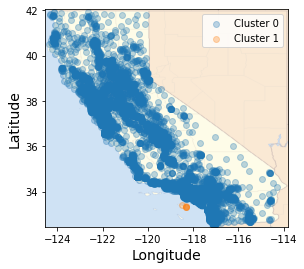

________________________________________________________
FOR K=3 CLUSTERS:
SSE (on scaled data) 6.37124290995714
Cluster 0 contains 5 houses
MEAN:
longitude               -118.35400
latitude                  33.35800
housing_median_age        42.40000
total_rooms             1574.60000
total_bedrooms           420.40000
population               668.00000
households               276.60000
median_income              2.74442
median_house_value    380440.00000
dtype: float64
Standard Divation:
longitude                 0.070569
latitude                  0.040866
housing_median_age       13.164346
total_rooms             707.545264
total_bedrooms          169.320111
population              301.691067
households              113.200265
median_income             0.444180
median_house_value    80559.561816
dtype: float64
Cluster 1 contains 2372 houses
MEAN:
longitude               -119.185527
latitude                  35.247901
housing_median_age        17.575042
total_rooms             6877.

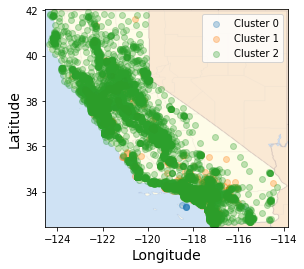

________________________________________________________
FOR K=4 CLUSTERS:
SSE (on scaled data) 4.224580451758798
Cluster 0 contains 10120 houses
MEAN:
longitude               -118.546446
latitude                  34.221278
housing_median_age        29.985672
total_rooms             2216.433893
total_bedrooms           459.190310
population              1283.650988
households               436.074407
median_income              4.249048
median_house_value    243854.576087
dtype: float64
Standard Divation:
longitude                  1.411420
latitude                   1.222299
housing_median_age        11.417782
total_rooms             1115.037707
total_bedrooms           225.048863
population               647.565546
households               207.370805
median_income              2.082565
median_house_value    112692.128070
dtype: float64
Cluster 1 contains 5 houses
MEAN:
longitude               -118.35400
latitude                  33.35800
housing_median_age        42.40000
total_rooms 

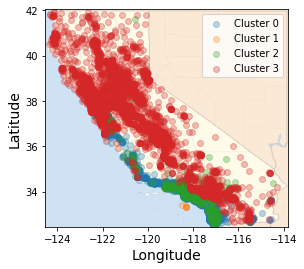

________________________________________________________
FOR K=5 CLUSTERS:
SSE (on scaled data) 4.649704655814432
Cluster 0 contains 5 houses
MEAN:
longitude               -118.35400
latitude                  33.35800
housing_median_age        42.40000
total_rooms             1574.60000
total_bedrooms           420.40000
population               668.00000
households               276.60000
median_income              2.74442
median_house_value    380440.00000
dtype: float64
Standard Divation:
longitude                 0.070569
latitude                  0.040866
housing_median_age       13.164346
total_rooms             707.545264
total_bedrooms          169.320111
population              301.691067
households              113.200265
median_income             0.444180
median_house_value    80559.561816
dtype: float64
Cluster 1 contains 3029 houses
MEAN:
longitude               -119.167055
latitude                  35.164655
housing_median_age        18.905910
total_rooms             5164

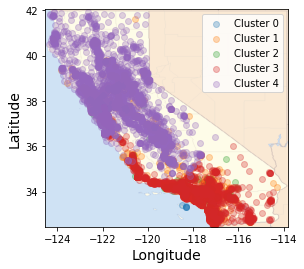

________________________________________________________
FOR K=6 CLUSTERS:
SSE (on scaled data) 6.661701731521838
Cluster 0 contains 2228 houses
MEAN:
longitude               -119.197451
latitude                  35.290094
housing_median_age        17.932675
total_rooms             5881.669659
total_bedrooms          1211.664858
population              3084.468582
households              1107.912029
median_income              4.059648
median_house_value    214376.697487
dtype: float64
Standard Divation:
longitude                  1.956524
latitude                   1.892540
housing_median_age         9.032792
total_rooms             1909.513415
total_bedrooms           352.733416
population               975.767477
households               311.577830
median_income              1.735397
median_house_value    105770.191850
dtype: float64
Cluster 1 contains 223 houses
MEAN:
longitude               -118.932601
latitude                  35.087399
housing_median_age        11.457399
total_ro

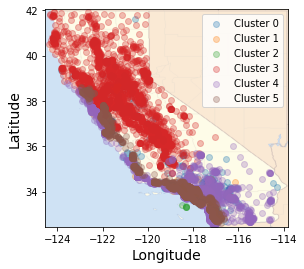

________________________________________________________
FOR K=7 CLUSTERS:
SSE (on scaled data) 3.527736692984497
Cluster 0 contains 211 houses
MEAN:
longitude               -118.947393
latitude                  35.097583
housing_median_age        11.303318
total_rooms            15637.658768
total_bedrooms          2922.314286
population              7634.170616
households              2661.872038
median_income              4.673846
median_house_value    226261.639810
dtype: float64
Standard Divation:
longitude                 1.947876
latitude                  1.949643
housing_median_age        7.267209
total_rooms            5247.197117
total_bedrooms          845.919440
population             3276.735287
households              777.731823
median_income             1.592581
median_house_value    98813.701670
dtype: float64
Cluster 1 contains 2205 houses
MEAN:
longitude               -122.262571
latitude                  37.800331
housing_median_age        38.416780
total_rooms      

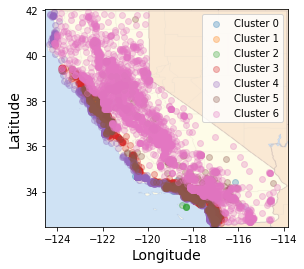

________________________________________________________
FOR K=8 CLUSTERS:
SSE (on scaled data) 6.339500177327302
Cluster 0 contains 2521 houses
MEAN:
longitude               -119.402578
latitude                  35.048596
housing_median_age        26.098770
total_rooms             2772.983340
total_bedrooms           458.746394
population              1217.449425
households               440.459738
median_income              6.574037
median_house_value    363616.713606
dtype: float64
Standard Divation:
longitude                 1.840192
latitude                  1.690341
housing_median_age       11.649791
total_rooms            1285.400158
total_bedrooms          216.627218
population              574.406224
households              202.515539
median_income             2.234340
median_house_value    97343.747169
dtype: float64
Cluster 1 contains 207 houses
MEAN:
longitude               -118.983333
latitude                  35.120483
housing_median_age        11.275362
total_rooms      

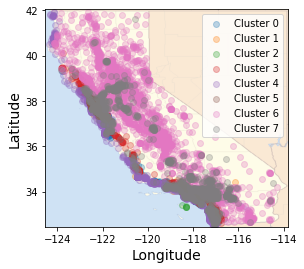

________________________________________________________
FOR K=9 CLUSTERS:
SSE (on scaled data) 6.874379410096014
Cluster 0 contains 2494 houses
MEAN:
longitude               -119.327899
latitude                  34.735064
housing_median_age        29.867281
total_rooms             2320.139936
total_bedrooms           493.957792
population              1236.902967
households               460.179230
median_income              3.778084
median_house_value    241692.917803
dtype: float64
Standard Divation:
longitude                  2.338674
latitude                   2.295176
housing_median_age        11.715389
total_rooms             1219.695482
total_bedrooms           251.650199
population               689.864368
households               229.274319
median_income              1.579256
median_house_value    117181.969410
dtype: float64
Cluster 1 contains 127 houses
MEAN:
longitude               -118.765984
latitude                  34.849843
housing_median_age         9.858268
total_ro

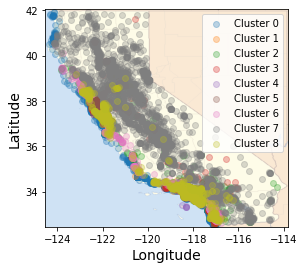

________________________________________________________
FOR K=10 CLUSTERS:
SSE (on scaled data) 6.801279967232068
Cluster 0 contains 2 houses
MEAN:
longitude               -119.6050
latitude                  34.9950
housing_median_age        12.5000
total_rooms            28881.0000
total_bedrooms          5632.0000
population             32124.0000
households              5425.5000
median_income              2.4408
median_house_value    126600.0000
dtype: float64
Standard Divation:
longitude                 3.090057
latitude                  2.326381
housing_median_age        2.121320
total_rooms            5297.644005
total_bedrooms         1149.755626
population             5031.771855
households              928.431204
median_income             0.186818
median_house_value    11030.865787
dtype: float64
Cluster 1 contains 113 houses
MEAN:
longitude               -118.767522
latitude                  34.880354
housing_median_age         9.274336
total_rooms            18286.699115
t

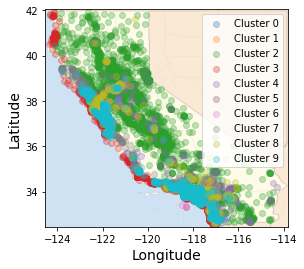

________________________________________________________


In [ ]:
# Your code goes here
def cluster_dataframes(cluster_membership):
  cluster_dataframes = []
  for _ in range(len(cluster_membership)):
    cluster_dataframes.append(pd.DataFrame(columns=data.columns))

  for i in range(len(data)):
    for j in range(len(cluster_dataframes)):
      if i in cluster_membership[j]:
        cluster_dataframes[j] = cluster_dataframes[j].append(data.iloc[i,0:])

  return cluster_dataframes

def report_and_visualize(num_clust):
  print(f"FOR K={num_clust} CLUSTERS:")

  cluster_membership, error = k_means(housing_prepared, k=num_clust, itters=100, dist_p=2)
  print("SSE (on scaled data)", error)

  cluster_data = cluster_dataframes(cluster_membership)
  for j in range(len(cluster_data)):
    print(f"Cluster {j} contains {len(cluster_data[j])} houses")
    print("MEAN:")
    print(cluster_data[j].mean())
    print("Standard Divation:")
    print(cluster_data[j].std())

  cluster_data_points_x = []
  cluster_data_points_y = []
  for i in range(num_clust):
    cluster_data_points_x.append([])
    cluster_data_points_y.append([])

  for i in range(len(data)):
    for j in range(num_clust):
      if i in cluster_membership[j]:
        cluster_data_points_x[j].append(data['longitude'][i])
        cluster_data_points_y[j].append(data['latitude'][i])

  california_img=mpimg.imread('/content/california.png')
  for j in range(num_clust):
    plt.scatter(cluster_data_points_x[j], cluster_data_points_y[j], label=f"Cluster {j}", alpha=0.3)

  plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
            cmap=plt.get_cmap("jet"))
  plt.ylabel("Latitude", fontsize=14)
  plt.xlabel("Longitude", fontsize=14)

  plt.legend(fontsize=10, loc='upper right')
  # save_fig("california_housing_prices_plot")
  plt.show()
  print(f"________________________________________________________")

for i in range(2,11):
  report_and_visualize(i)


For 2 clusters my algorithm favors making a cluster of supper expensive island houses and then another cluster of all other houses in California. They do not compare with the cities around california. The split is island or mainland California.
As the number of clusters increases, more interesting cluster housing partitions emerge. For 3 cluster there is {island houses, city/suberb houses, rural houses}. 4 clusters is largely similar however, there is an additional category of rural but costal houses which makes some sense. Interestingly the Northern California Southern California split occurs for me at k=5 clusters. At 6 clusters the city centers and suberbs of LA and San Francisco become apparent. 7 clusters shows distent layers moving away from the coast. 8 clusters largely just show the urban/rual split. 9 and 10 are over constrained just showing more granularity as you move futher from costal/city centers.

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge.



  To understand the California housing crisis you first need to understand the current california housing layout. There is great disparety between rich housing - by and large along the coast and in the two major cities (LA and SF+Silicon Valley) - and poor areas of California - by and large the interior and rual california with the exception of the centeral valley. Just based of the clustering of this data one may say a solution is to build more housing where it is cheap - in the California interior. However the problem with this approach is that there is not enough drinkable water infastruture to support increased housing.
  
  Additionally it is the major California cities where the people want to live anyways. So I would say the best and most intutative approach would be to add high density housing in and near cities. These would be lower cost than the single family house alterative and provide more shelter for the increasingly homeless populations of CA.

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!